## Granulometrie

In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import spatial
from skimage.exposure import histogram
from skimage.io import imread
from skimage.morphology import disk, binary_opening
from skimage.filters import gaussian
from skimage.measure import label, regionprops

np.random.seed(2)

In [4]:
def granulometry(data):
    im = data
    granulo = [0]
    sizes = [0]
    nb_separation = []
    labels_prev, nb_labels = label(im, return_num=True, connectivity=2)
    nb_gouttes = [nb_labels]
    n = 1

    if np.amax(im) > 1:
        sum_ref = np.sum(im.flatten()/255)
    else : sum_ref = np.sum(im.flatten())


    while np.any(im):
        labels_prev = label(im, connectivity=2)
        nb_sep = 0
        
        ##### AFFICHAGE AVANT OUVERTURE
        fig = plt.figure()
        ax1 = fig.add_subplot(121)
        ax1.imshow(im, cmap='gray')
        ax1.set_title("AVANT OUVERTURE")
        ##### FIN AFFICHAGE AVANT OUVERTURE
        
        struct = disk(n).astype(np.bool)
        im = binary_opening(data, selem=struct)
        labels_cur, nb_labels_cur = label(im, return_num=True, connectivity=2)
        histo, bins = histogram(labels_cur)
        dico_gouttes = {}
        
        ##### AFFICHAGE APRES OUVERTURE
        ax2 = fig.add_subplot(122)
        ax2.imshow(im, cmap='gray')
        ax2.set_title("APRES OUVERTURE")

        for value in bins[1:]: # on part du principe que le fond à la plus grande valeur de pixels
            blob = np.where(labels_cur==value, 255, 0)
            # s'il y chevauchement d'une goutte actuelle sur 2 éléments connexes différents de l'image précédente,
            # on prend en celle avec la valeur d'image connexe la plus grande (donc pas le fond)
            valeur_goutte = np.amax(np.unique(labels_prev[np.logical_and(blob, labels_prev)]))
            if valeur_goutte in dico_gouttes:
                prop = regionprops(blob)
                x, y = prop[0].centroid
                ax2.plot(y, x, 'r.', ms=2)
                val = dico_gouttes[valeur_goutte]
                blob = np.where(labels_cur==val, 255, 0)
                prop = regionprops(blob)
                x, y = prop[0].centroid
                ax2.plot(y, x, 'r.', ms=2)
                nb_sep += 1
            else:
                dico_gouttes[valeur_goutte] = value
        plt.show()
        ##### FIN AFFICHAGE APRES OUVERTURE
        
        nb_separation += [nb_sep]
        nb_gouttes += [nb_labels_cur]
        granulo += [1-im.sum()/sum_ref]
        sizes += [n]
        n += 1
            
    #Calcul derivee: spectre granulometrique
    y_spectre=[]
    x_spectre=[]
    nb_gouttes_par_taille = []
    for i in range(0,len(granulo)-1):
        y_spectre += [granulo[i+1]-granulo[i]]
        # Nombre de gouttes disparues à chaque étape
        nb_gouttes_par_taille += [nb_gouttes[i] - nb_gouttes[i+1] + nb_separation[i]]
    nb_gouttes_par_taille += [nb_gouttes[-1]]
    nb_taches = nb_gouttes[0] # Nb de taches comptées à l'étape initiale
    return granulo, sizes, nb_gouttes_par_taille, y_spectre, nb_taches

In [5]:
# Génération de données de test
n = 10
l = 256
im = np.zeros((l, l))
points = l*np.random.random((2, n**2))
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = gaussian(im, sigma=l/(4.*n))
im_test = im > im.mean()

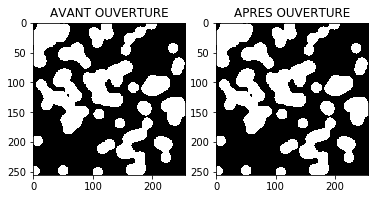

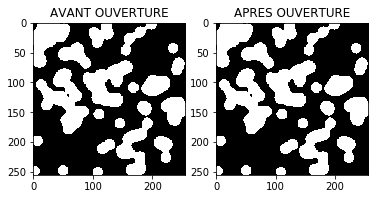

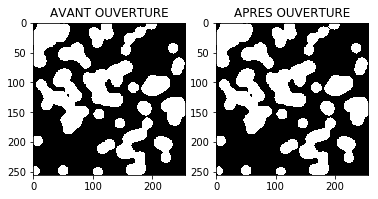

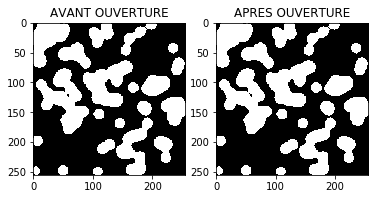

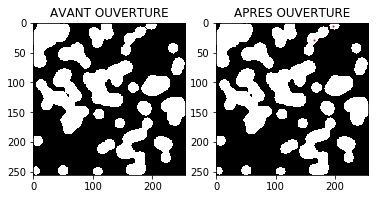

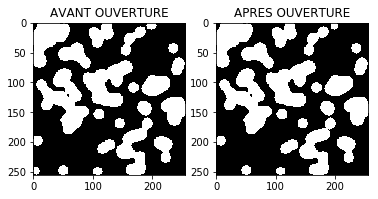

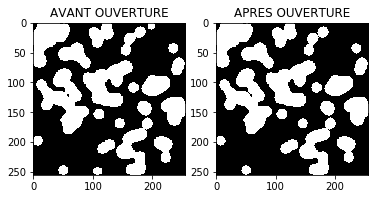

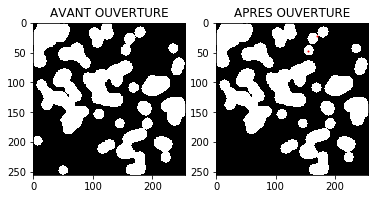

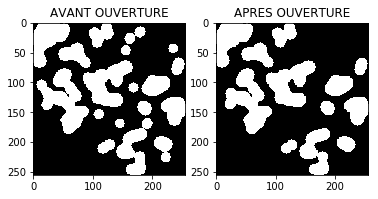

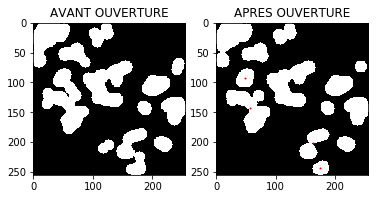

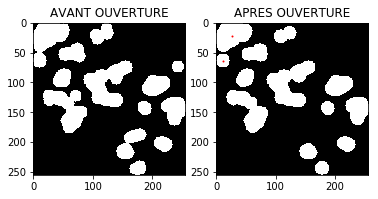

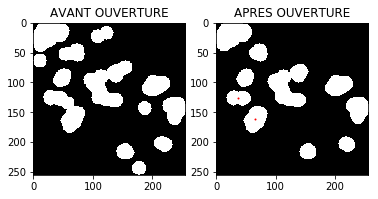

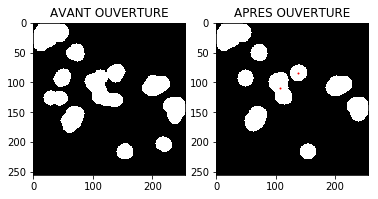

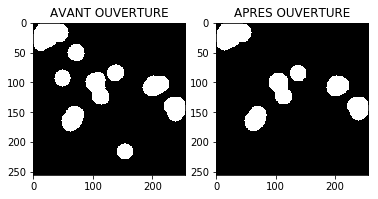

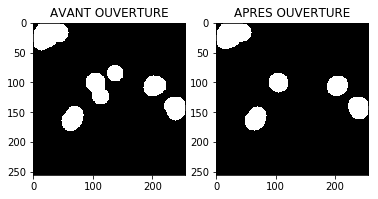

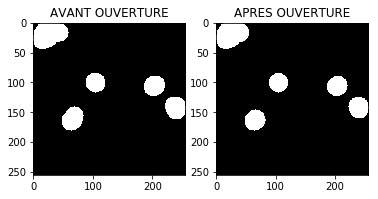

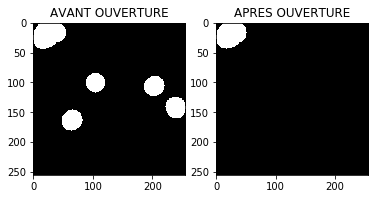

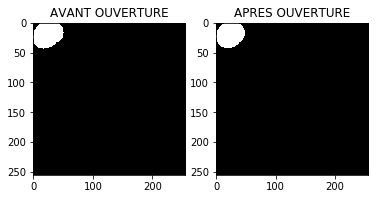

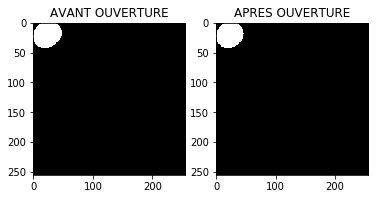

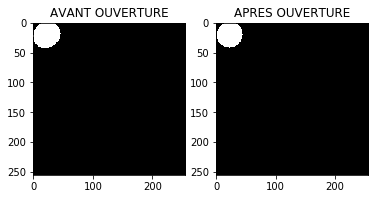

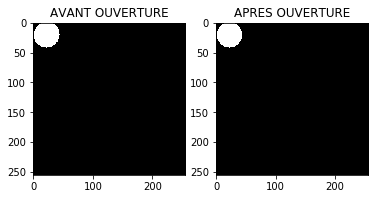

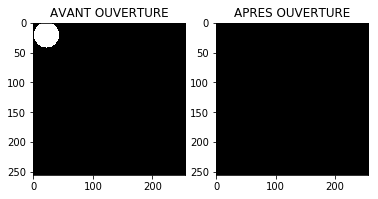

In [6]:
# Test de granulometry
granulo, sizes, nb, spectre, nb_tache = granulometry(im_test)

Le choix de l'élément structurant joue un rôle important dans la granulométrie car c'est lui qui va déterminer quels objets vont être "ouverts" (disparaitre) dans/de l'image et comment l'érosion va se faire. Ici ce sont des disques qui sont utilisés car leur forme se rapproche de la forme d'une goutte (contrairement à un carré).

In [7]:
# Affichage d'élements structurants
for n in range(1, 5):
    elem = disk(n)
    print("--"*5 + "n="+str(n) + "--"*5)
    print(elem)

----------n=1----------
[[0 1 0]
 [1 1 1]
 [0 1 0]]
----------n=2----------
[[0 0 1 0 0]
 [0 1 1 1 0]
 [1 1 1 1 1]
 [0 1 1 1 0]
 [0 0 1 0 0]]
----------n=3----------
[[0 0 0 1 0 0 0]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [1 1 1 1 1 1 1]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [0 0 0 1 0 0 0]]
----------n=4----------
[[0 0 0 0 1 0 0 0 0]
 [0 0 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 0 0]
 [0 0 0 0 1 0 0 0 0]]


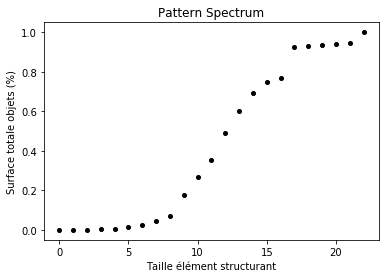

In [8]:
# Affichage Pattern Spectrum
plt.figure()
plt.title("Pattern Spectrum")
plt.xlabel("Taille élément structurant")
plt.ylabel("Surface totale objets (%)")
plt.plot(sizes, granulo, 'ok', ms=4)
plt.show()

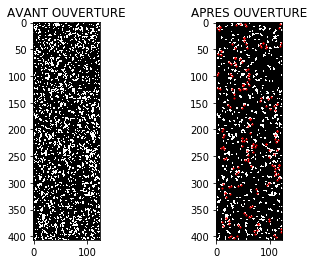

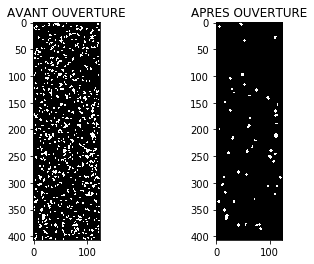

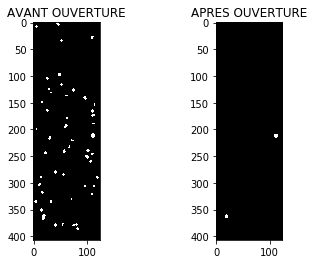

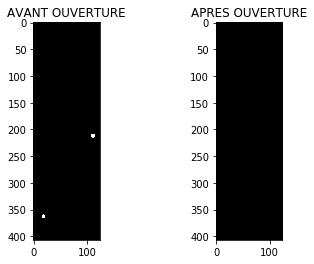

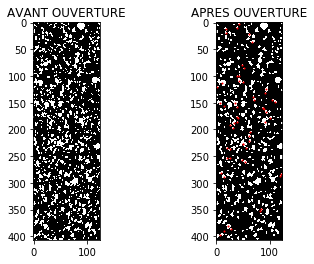

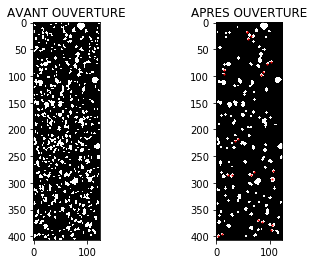

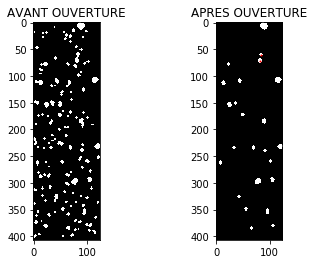

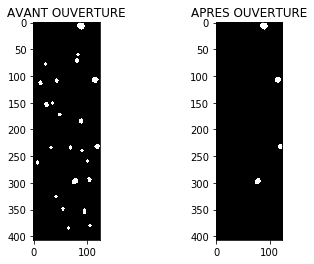

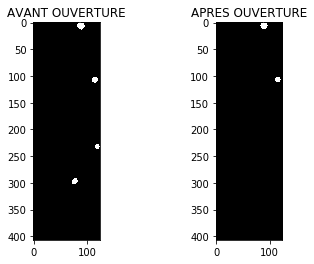

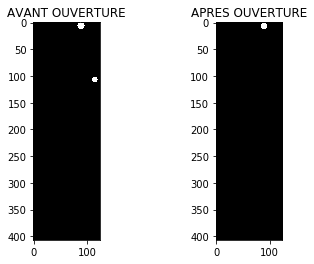

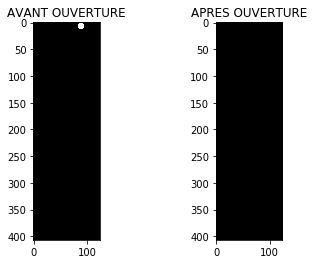

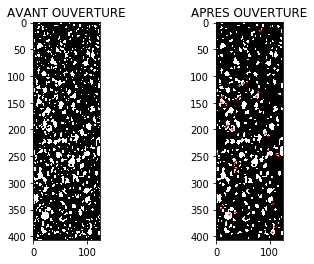

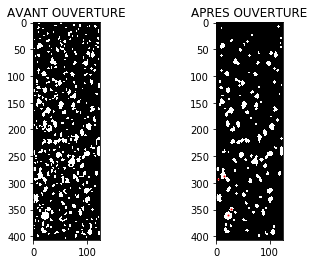

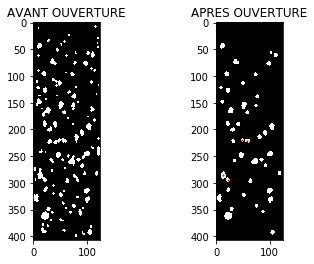

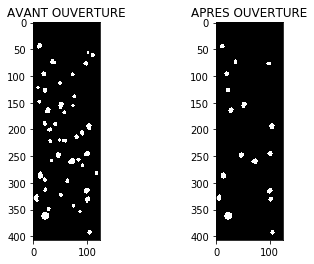

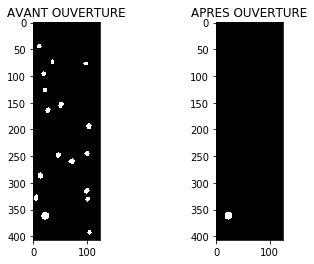

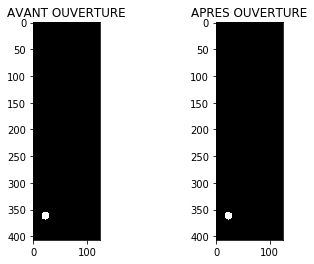

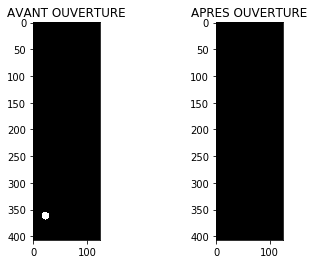

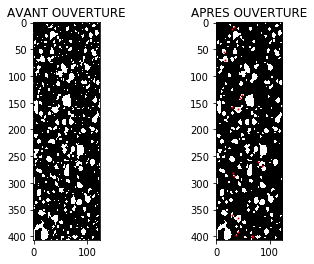

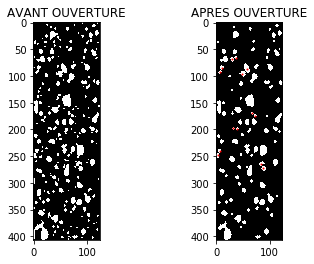

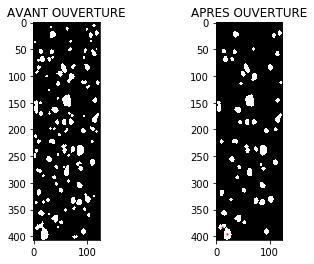

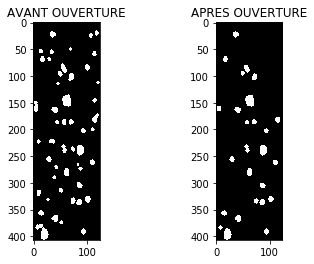

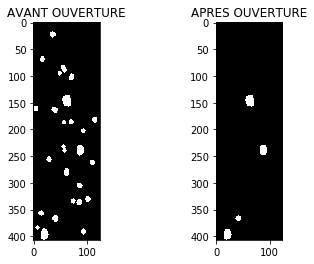

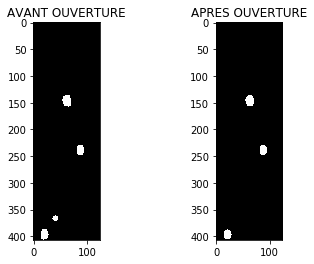

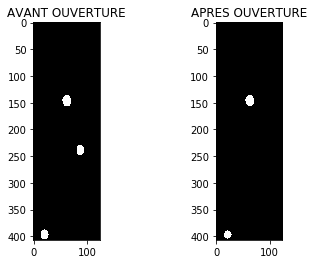

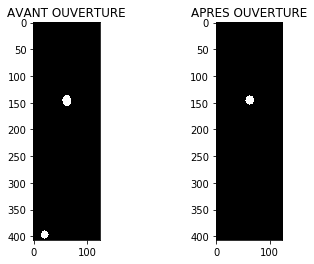

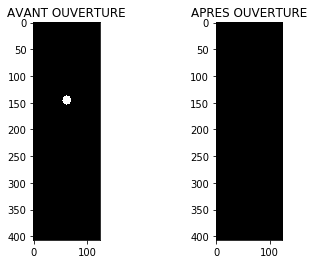

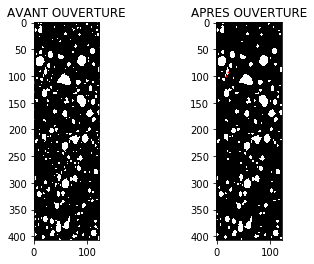

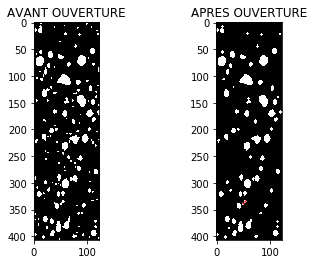

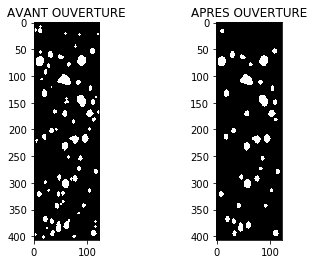

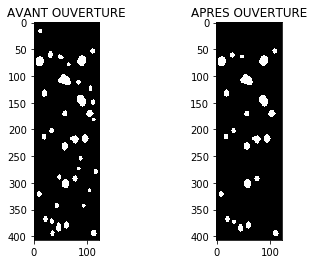

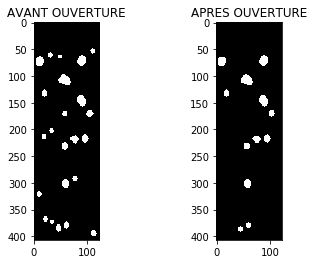

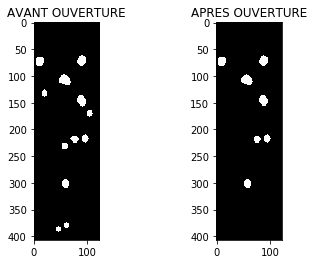

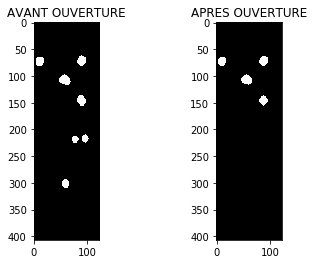

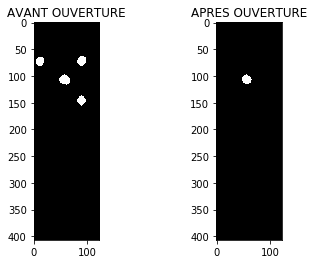

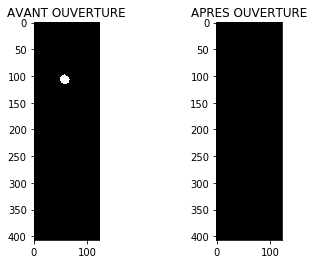

[111, 87, 33, 14, 11, 5, 3, 3, 1, 0]
Nombre total de gouttes : 268
Nombre total de taches : 266
[111, 87, 33, 14, 11, 5, 3, 3, 1, 0]
Nombre total de gouttes : 268
Nombre total de taches : 266
[111, 87, 33, 14, 11, 5, 3, 3, 1, 0]
Nombre total de gouttes : 268
Nombre total de taches : 266
[111, 87, 33, 14, 11, 5, 3, 3, 1, 0]
Nombre total de gouttes : 268
Nombre total de taches : 266
[111, 87, 33, 14, 11, 5, 3, 3, 1, 0]
Nombre total de gouttes : 268
Nombre total de taches : 266


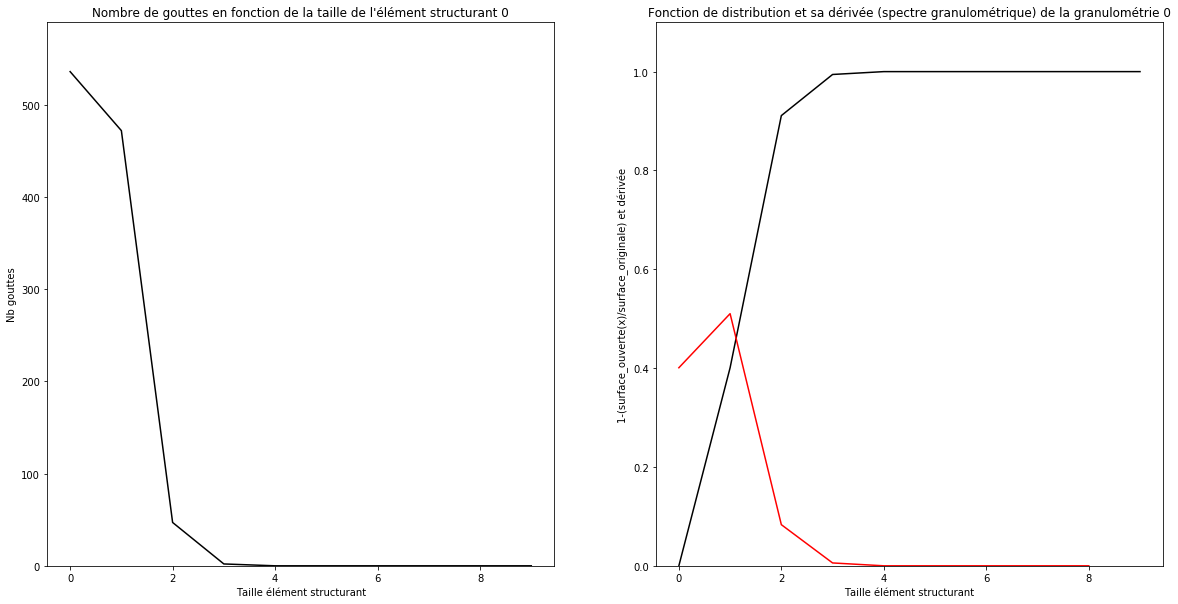

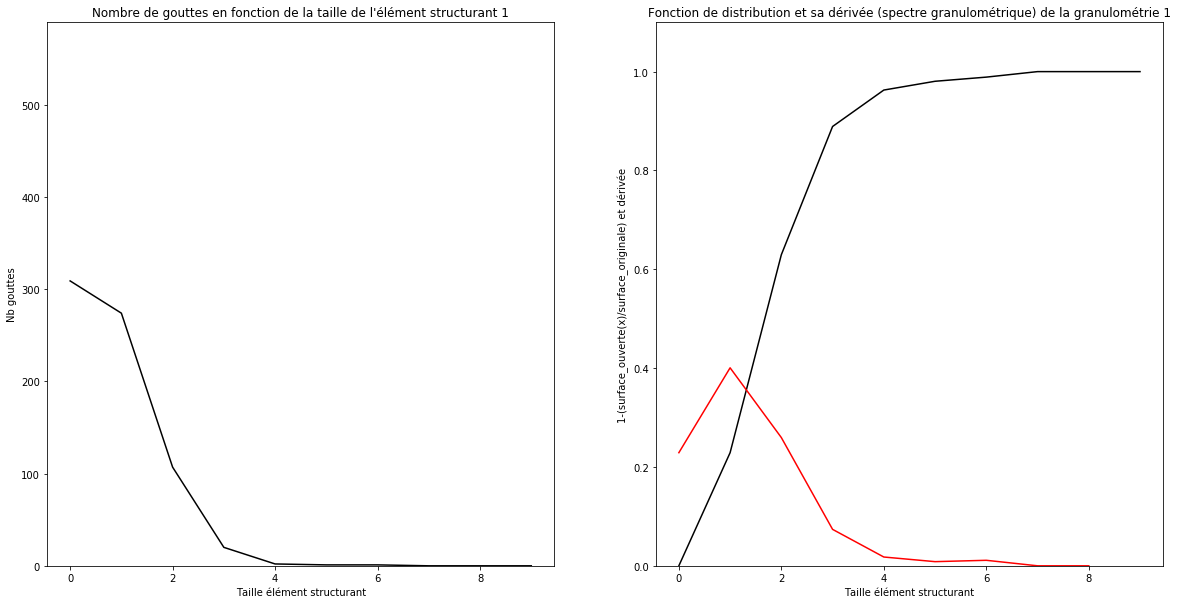

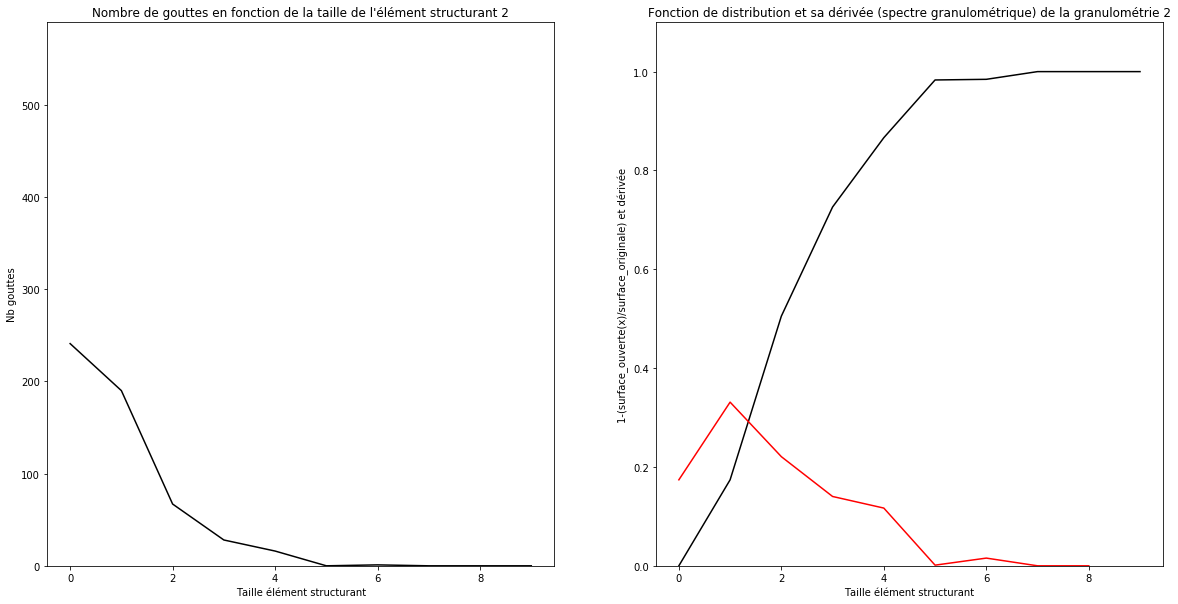

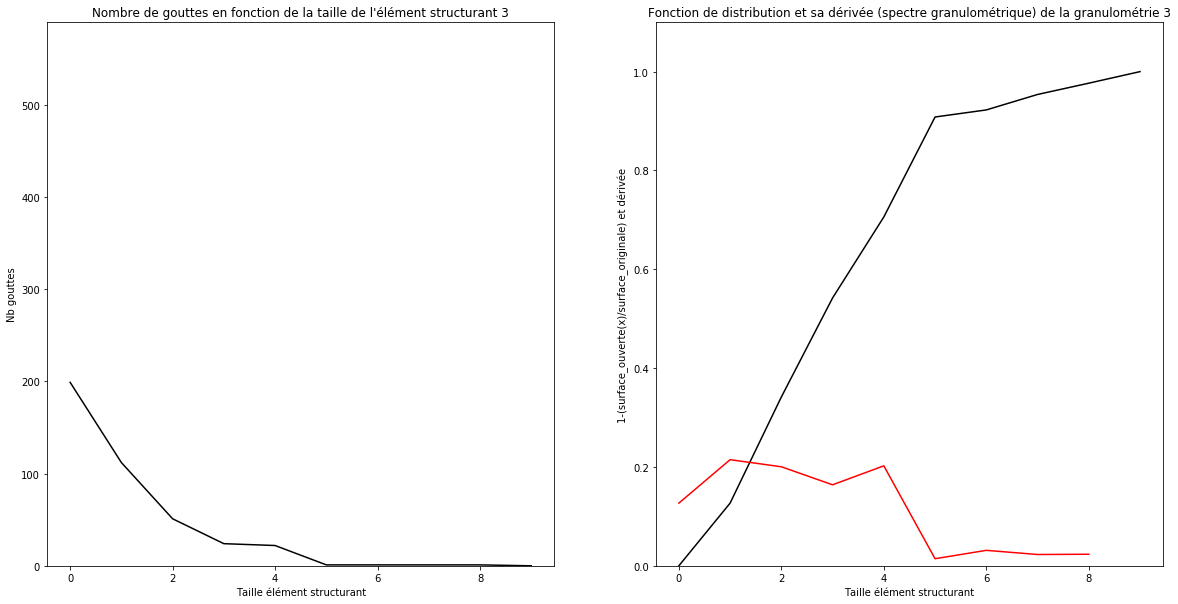

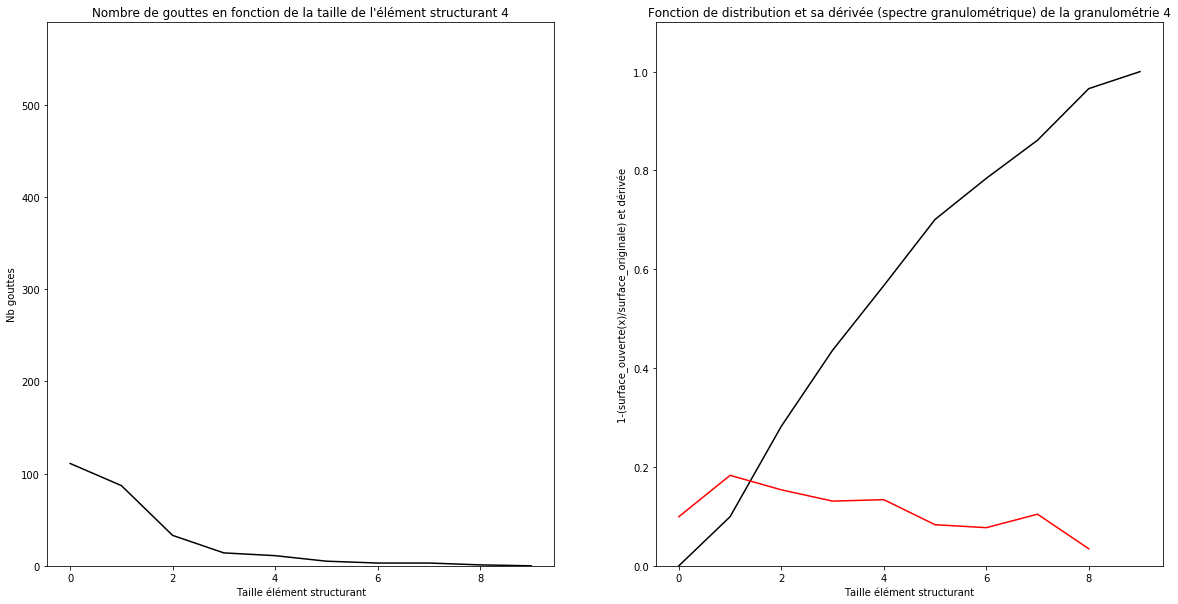

In [9]:
# Test granulometry sur papier hydrosensible
nb_images = 4 # nb d'images à afficher (4 max)
images = [imread("images/Papier_"+str(n)+".png") for n in range(0, nb_images+1)]
results = []
max_size = -1
max_height = -1
max_nb_gouttes = -1
cpt = 0
for im in images:
    granulo, sizes, nb_drops, spectre_y, nb_tache = granulometry(im)
    results.append((granulo, nb_drops, spectre_y))
    max_size = len(sizes) if len(sizes) > max_size else max_size
    max_height = max(granulo) if max(granulo) > max_height else max_height
    max_nb_gouttes = max(nb_drops) if max(nb_drops) > max_nb_gouttes else max_nb_gouttes
    
for res, nb_g, spectre in results:
    if len(res) < max_size:
        for i in range(max_size-len(res)): # On rajoute des valeurs pour tracer des graphes sur le même axe des abscisses
            res.append(1) # pour la fonction de distribution de la taille, la valeur asymptotique est 1
            nb_g.append(0) # nombre de gouttes 0 quand tout est ouvert
            spectre.append(0) # pas de variation pour les tailles trop grande
    sizes = range(max_size)
    
    print(nb_drops)
    print("Nombre total de gouttes :", sum(nb_drops))
    print("Nombre total de taches :", nb_tache)
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(121)
    ax1.set_title("Nombre de gouttes en fonction de la taille de l'élément structurant "+str(cpt))
    ax1.set_xlabel("Taille élément structurant")
    ax1.set_ylabel("Nb gouttes")
    ax1.set_ylim(0, max_nb_gouttes*1.1)
    ax1.plot(sizes, nb_g, '-k', ms=4)
    
    ax2 = fig.add_subplot(122)
    ax2.set_title("Fonction de distribution et sa dérivée (spectre granulométrique) de la granulométrie "+str(cpt))
    ax2.set_xlabel("Taille élément structurant")
    ax2.set_ylabel("1-(surface_ouverte(x)/surface_originale) et dérivée")
    ax2.set_ylim(0, max_height*1.1)
    ax2.plot(sizes, res, '-k', ms=4)
    ax2.plot(sizes[:-1], spectre, '-r', ms=4)
    
    cpt += 1
plt.show()


On a ici (à gauche) le nombre de gouttes en fonction de la taille de l'élément structurant (rayon du disque), soit . Et la fonction de répartition granulométrique ainsi que sa dérivée, le spectre granulométrique, à droite.

Le spectre granulométrique ne descend jamais vraiment à 0 (sauf quand l'image est totalement ouverte : plus d'objets) car l'opération d'ouverture érode toujours un peu les objets. Les surfaces à l'itération n et n+1 ne sont donc jamais égales.


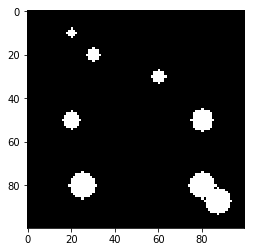

In [10]:
# Test du calcul de moyenne
# Création de données de synthèse
x, y = np.indices((100, 100))
x_c = (10, 20, 30, 50, 50, 80, 80, 87) # lignes
y_c = (20, 30, 60, 20, 80, 25, 80, 87) # colonnes
r = (2, 3, 3, 4, 5, 6, 6, 6, 2, 3) # rayon
image = np.zeros((100, 100))
for i in range(len(x_c)):
    mask_circle1 = (x - x_c[i])**2 + (y - y_c[i])**2 <= r[i]**2
    image = np.logical_or(image, mask_circle1)

plt.figure()
plt.imshow(image, cmap='gray')
plt.show()

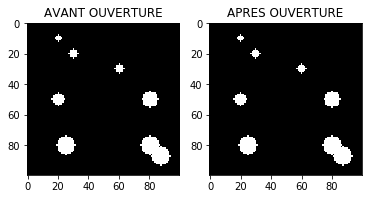

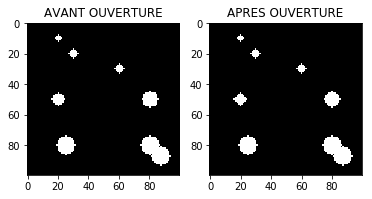

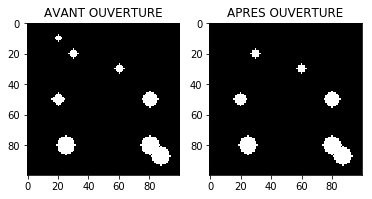

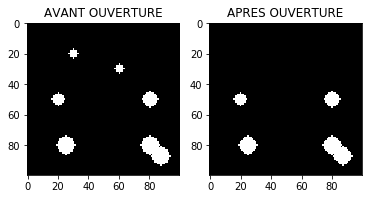

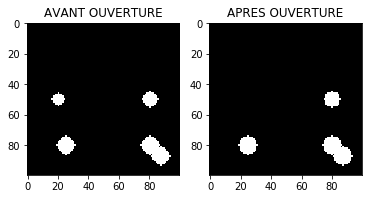

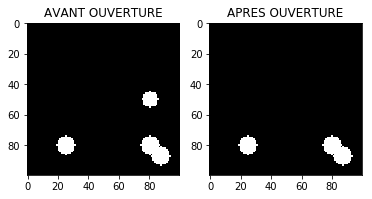

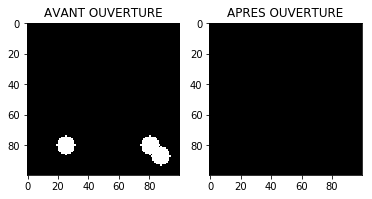

[0 1 2 3 4 5 6 7]
[ 0.01509434  0.03018868  0.03207547  0.12830189  0.02075472  0.15283019
  0.62075472]
Taille moyenne d'une goutte :  122.255374491
Taille moyenne d'une goutte - vraie : 57.8053048261


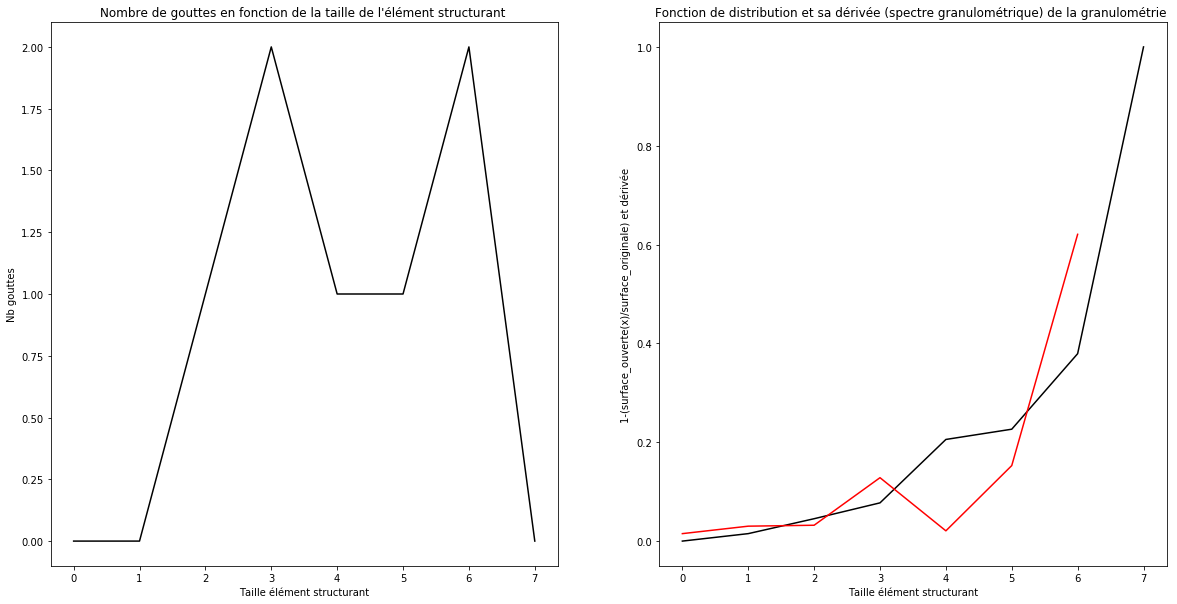

In [11]:
# Test du calcul de moyenne
# Application de la granulométrie
granulo, sizes, nb_drops, spectre_y, nb_tache = granulometry(image)

granulo = np.asarray(granulo)
sizes = np.asarray(sizes)
spectre_y = np.asarray(spectre_y)

#########VERIFIER LE CALCUL#########
print(sizes[:])
print(spectre_y)
taille_elem = np.pi*sizes[1:]**2
taille_moyenne = (spectre_y*taille_elem).sum()/spectre_y.sum()
print("Taille moyenne d'une goutte : ", taille_moyenne)

moyenne = np.asarray([np.pi*x**2 for x in r]).sum()/len(r)
#moyenne = np.asarray([np.count_nonzero(disk(x)) for x in r]).sum()/len(r)
print("Taille moyenne d'une goutte - vraie :", moyenne)
#########VERIFIER LE CALCUL#########
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax1.set_title("Nombre de gouttes en fonction de la taille de l'élément structurant ")
ax1.set_xlabel("Taille élément structurant")
ax1.set_ylabel("Nb gouttes")
ax1.plot(sizes, nb_drops, '-k', ms=4)

ax2 = fig.add_subplot(122)
ax2.set_title("Fonction de distribution et sa dérivée (spectre granulométrique) de la granulométrie ")
ax2.set_xlabel("Taille élément structurant")
ax2.set_ylabel("1-(surface_ouverte(x)/surface_originale) et dérivée")
ax2.plot(sizes, granulo, '-k', ms=4)
ax2.plot(sizes[:-1], spectre_y, '-r', ms=4)
plt.show()
